<p align = "center"><strong>GLOBAL SPATIAL AUTOCORRELATION: GEARY C <strong></p>

<p><b>By: Jefferson C.</p>

---

#### __Geary’s Index (Global Geary C)__

__Def.__  

Medida **Global de autocorrelación espacial** que cuantifica el grado de **disimilitud espacial** entre los valores de una variable observados en unidades espaciales vecinas, de acuerdo con una matriz de pesos espaciales.  
El índice de Geary es **más sensible a diferencias locales** que el índice de Moran.

El índice toma valores :
- $\to$ __0__ fuerte autocorrelación espacial positiva (valores similares)

- $\approx$ __1__ ausencia de autocorrelación espacial

- $\to$ __> 1__ autocorrelación espacial negativa (valores disímiles)

__Formula:__

Suma de pesos espaciales
$$
S_0 = \sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}
$$

Media y varianza global
$$
\bar{x}=\frac{1}{n}\sum_{i=1}^{n}x_i
\qquad
s^2 = \frac{1}{n-1}\sum_{i=1}^{n}(x_i-\bar{x})^2
$$

Índice Global de Geary
$$
C =
\frac{(n-1)}{2S_0}
\;
\frac{\sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}(x_i-x_j)^2}
{\sum_{i=1}^{n}(x_i-\bar{x})^2}
$$


<p align = 'center'>
<em>El índice global de Geary evalúa la autocorrelación espacial a partir de las diferencias cuadráticas entre unidades vecinas, siendo especialmente sensible a discontinuidades espaciales.</em>
</p>


donde : 
- $w_{ij}$ elemento de la matriz de pesos espaciales $W$.
- $x_i$ valor observado de la variable de interés en la unidad espacial $i$.
- $x_j$ valor observado de la variable de interés en la unidad espacial contigua (vecina de $x_i$).
- $n$ número de unidades espaciales.
- $\bar{x}$ media global de la variable.
- $s^2$ varianza muestral global de la variable.


__Reference:__
- Geary, R. C. (1954). *The contiguity ratio and statistical mapping*. The Incorporated Statistician, 5(3), 115–145.  
  https://www.jstor.org/stable/2986645


In [4]:
# DEPENDENCIES 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

    # Import data (shp)
import geopandas as gpd
    # Weight Matrix
from libpysal.weights import Queen, Rook, W, lag_spatial,w_subset
    # Global index (GEARY)
from esda.geary import Geary
    # Warnings
import warnings
import contextlib

def global_geary(
    gdf,
    fields,
    contiguities=("queen", "rook", "bishop"),
    permutations=9999,
    alpha=0.05,
    drop_islands=True,
    standardize_x=True,
    use_index=True,
    style="seaborn-v0_8",
    silence_warnings=True,
    dashboard_field=None,
    figsize=(15, 10),
):
    """
    GLOBAL Geary's C for multiple variables and contiguities (Queen/Rook/Bishop).

    Assumptions:
      - gdf is already CLEAN (numeric fields, no NaN/inf values)
      - geometries are valid

    Returns:
      1) results_table : long-format table with Global Geary results (includes var_x)
      2) fig           : dashboard (scatter-like + permutation histogram) for ONE variable (dashboard_field)
      3) out           : dictionary with internal objects (w, geary, simulated C, etc.)
    """

    # BASIC INPUT HANDLING
    if isinstance(fields, str):
        fields = [fields]
    fields = list(fields)

    missing = [c for c in fields if c not in gdf.columns]
    if missing:
        raise ValueError(f"These fields are missing in gdf: {missing}")

    contiguities = tuple(c.lower().strip() for c in contiguities)
    allowed = {"queen", "rook", "bishop"}
    if any(c not in allowed for c in contiguities):
        raise ValueError(f"contiguities must be in {allowed}")

    if dashboard_field is None:
        dashboard_field = fields[0]
    if dashboard_field not in fields:
        raise ValueError("dashboard_field must be inside fields")

    if not use_index:
        warnings.warn(
            "use_index=False may misalign island IDs with gdf.index when dropping islands. "
            "Recommended: use_index=True.",
            UserWarning,
        )

    # CONTEXT MANAGERS (avoid global side effects)
    @contextlib.contextmanager
    def _maybe_style(style_name):
        old = plt.rcParams.copy()
        try:
            plt.style.use(style_name)
            yield
        finally:
            plt.rcParams.update(old)

    @contextlib.contextmanager
    def _maybe_warnings(silence):
        if not silence:
            yield
            return
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                category=UserWarning,
                message=".*weights matrix is not fully connected.*",
            )
            warnings.filterwarnings(
                "ignore",
                category=FutureWarning,
                message=".*use_index.*",
            )
            yield

    # HELPERS
    def _zscore(x):
        # Population standardization (ddof=0); if sd=0 -> zeros
        sd = x.std(ddof=0)
        return (x - x.mean()) / sd if sd > 0 else x * 0.0

    def _build_weights(df):
        """
        Build weights for Queen/Rook/Bishop.
        Bishop = Queen - Rook (vertex-only).
        """
        wq = Queen.from_dataframe(df, use_index=use_index)
        wr = Rook.from_dataframe(df, use_index=use_index)

        out = {}
        if "queen" in contiguities:
            out["queen"] = wq
        if "rook" in contiguities:
            out["rook"] = wr
        if "bishop" in contiguities:
            ids = list(wq.id_order)
            neighbors = {
                i: list(set(wq.neighbors.get(i, [])) - set(wr.neighbors.get(i, [])))
                for i in ids
            }
            out["bishop"] = W(neighbors, id_order=ids)

        return out

    def _subset_drop_islands(w, df):
        """
        Subset weights to match df and optionally drop islands.
        """
        ids = list(df.index) if use_index else list(range(len(df)))
        w2 = w_subset(w, ids)

        islands_initial = list(getattr(w2, "islands", []))

        if drop_islands and islands_initial:
            df2 = df.drop(index=islands_initial).copy() if use_index else df.copy()
            ids2 = list(df2.index) if use_index else list(range(len(df2)))
            w2 = w_subset(w, ids2)
            return w2, df2, islands_initial

        return w2, df, islands_initial

    # RESULTS TABLE
    rows = []

    with _maybe_warnings(silence_warnings), _maybe_style(style):

        # Build full weights once
        w_full = _build_weights(gdf)

        # Loop over variables and contiguities
        for field in fields:
            for c in contiguities:

                # Subset weights and optionally drop islands
                w2, df2, islands_initial = _subset_drop_islands(w_full[c], gdf)
                w2.transform = "R"  # row-standardized weights (GeoDa style)

                x = df2[field].to_numpy()
                var_x = float(np.var(x, ddof=0))

                # Degenerate cases: too few obs or zero variance
                if len(x) < 3 or np.std(x, ddof=0) == 0:
                    rows.append(dict(
                        variable=field,
                        contiguity=c.upper(),
                        n=int(len(x)),
                        var_x=var_x,
                        Geary_C=np.nan,
                        E_C=1.0,  # under spatial randomness, E[C] ~ 1
                        z_sim=np.nan,
                        p_value_perm=np.nan,
                        significant_alpha=False,
                        permutations=int(permutations),
                        islands_initial=int(len(islands_initial)),
                        islands_removed=int(len(islands_initial)) if drop_islands else 0,
                        islands_remaining=int(len(getattr(w2, "islands", []))),
                        note="n<3 or zero variance",
                    ))
                    continue

                # Geary computation
                gc = Geary(x, w2, permutations=permutations)

                rows.append(dict(
                    variable=field,
                    contiguity=c.upper(),
                    n=int(len(x)),
                    var_x=var_x,
                    Geary_C=float(gc.C),
                    E_C=float(getattr(gc, "EC", 1.0)),       # if available, else 1.0
                    z_sim=float(getattr(gc, "z_sim", np.nan)),
                    p_value_perm=float(getattr(gc, "p_sim", np.nan)),
                    significant_alpha=bool(getattr(gc, "p_sim", 1.0) < alpha),
                    permutations=int(permutations),
                    islands_initial=int(len(islands_initial)),
                    islands_removed=int(len(islands_initial)) if drop_islands else 0,
                    islands_remaining=int(len(getattr(w2, "islands", []))),
                    note="",
                ))

        results_table = pd.DataFrame(rows)

        order = pd.CategoricalDtype(["QUEEN", "ROOK", "BISHOP"], ordered=True)
        results_table["contiguity"] = (
            results_table["contiguity"].astype(str).str.upper().astype(order)
        )
        results_table = (
            results_table.sort_values(["variable", "contiguity"])
            .reset_index(drop=True)
        )

        # DASHBOARD
        #   - (Left) a diagnostic plot: x_std vs lag(x_std) to visualize local smoothness
        #   - (Right) permutation histogram for Geary's C
        dash = {}
        kinds = list(contiguities)

        fig, axes = plt.subplots(len(kinds), 2, figsize=figsize)
        if len(kinds) == 1:
            axes = np.array([axes])

        for r, kind in enumerate(kinds):
            w2, df2, _ = _subset_drop_islands(w_full[kind], gdf)
            w2.transform = "R"

            x = df2[dashboard_field].to_numpy()
            gc = Geary(x, w2, permutations=permutations)

            # Standardize for the left diagnostic plot
            x_plot = _zscore(x) if standardize_x else x.copy()
            wx_plot = lag_spatial(w2, x_plot)

            dash[kind] = dict(
                gdf=df2,
                w=w2,
                x=x,
                geary=gc,
                x_plot=x_plot,
                wx_plot=wx_plot,
            )

            # Left: x vs spatial lag (diagnostic)
            ax_sc = axes[r, 0]
            ax_sc.scatter(x_plot, wx_plot, edgecolor="k", facecolor="none")
            ax_sc.axhline(0, color="gray", linestyle="--", linewidth=1)
            ax_sc.axvline(0, color="gray", linestyle="--", linewidth=1)
            ax_sc.set_title(f"{kind.upper()} — x vs lag(x) (C={gc.C:.3f})", fontweight="bold")
            ax_sc.set_xlabel(f"{dashboard_field} ({'std' if standardize_x else 'raw'})")
            ax_sc.set_ylabel("Spatial lag")

            # Right: permutation histogram for Geary's C 
            ax_ph = axes[r, 1]
            sim = getattr(gc, "sim", None)
            if sim is not None:
                ax_ph.hist(sim, bins=30, edgecolor="black")
                ax_ph.axvline(gc.C, linewidth=2)
                p_sim = getattr(gc, "p_sim", np.nan)
                ax_ph.set_title(f"{kind.upper()} — Permutations (p={p_sim:.4f})", fontweight="bold")
            else:
                ax_ph.text(0.5, 0.5, "No permutation distribution available", ha="center", va="center")
                ax_ph.set_title(f"{kind.upper()} — Permutations", fontweight="bold")

            ax_ph.set_xlabel("Geary's C")
            ax_ph.set_ylabel("Frequency")

        fig.suptitle(f"GLOBAL GEARY'S C — {dashboard_field}", y=1.02, fontsize=14, fontweight="bold")
        fig.tight_layout()

    out = {"dashboard": dash, "results_table": results_table}
    return results_table, fig, out

In [6]:
# Import data 
gdf = gpd.read_file("../healthindicators/HealthIndicators.shp")

,variable,contiguity,n,var_x,Geary_C,E_C,z_sim,p_value_perm,significant_alpha,permutations,islands_initial,islands_removed,islands_remaining,note
0,Below_evel,QUEEN,77,130.464095,0.534916,1.0,-5.817982,0.001,True,999,0,0,0,
1,Below_evel,ROOK,77,130.464095,0.530751,1.0,-5.826959,0.001,True,999,0,0,0,
2,Below_evel,BISHOP,31,76.040499,0.699182,1.0,-1.268780,0.109,False,999,46,46,0,
3,BirthRate,QUEEN,77,12.290258,0.682042,1.0,-4.280076,0.001,True,999,0,0,0,
4,BirthRate,ROOK,77,12.290258,0.668361,1.0,-4.291290,0.002,True,999,0,0,0,
5,BirthRate,BISHOP,31,12.934964,0.892096,1.0,-0.436907,0.341,False,999,46,46,0,
6,TeenB_Rate,QUEEN,77,779.234225,0.445842,1.0,-7.525161,0.001,True,999,0,0,0,
7,TeenB_Rate,ROOK,77,779.234225,0.445264,1.0,-7.059579,0.001,True,999,0,0,0,
8,TeenB_Rate,BISHOP,31,469.851093,0.689231,1.0,-1.334830,0.092,False,999,46,46,0,
9,Unemp_ment,QUEEN,77,48.806348,0.507256,1.0,-6.093544,0.001,True,999,0,0,0,


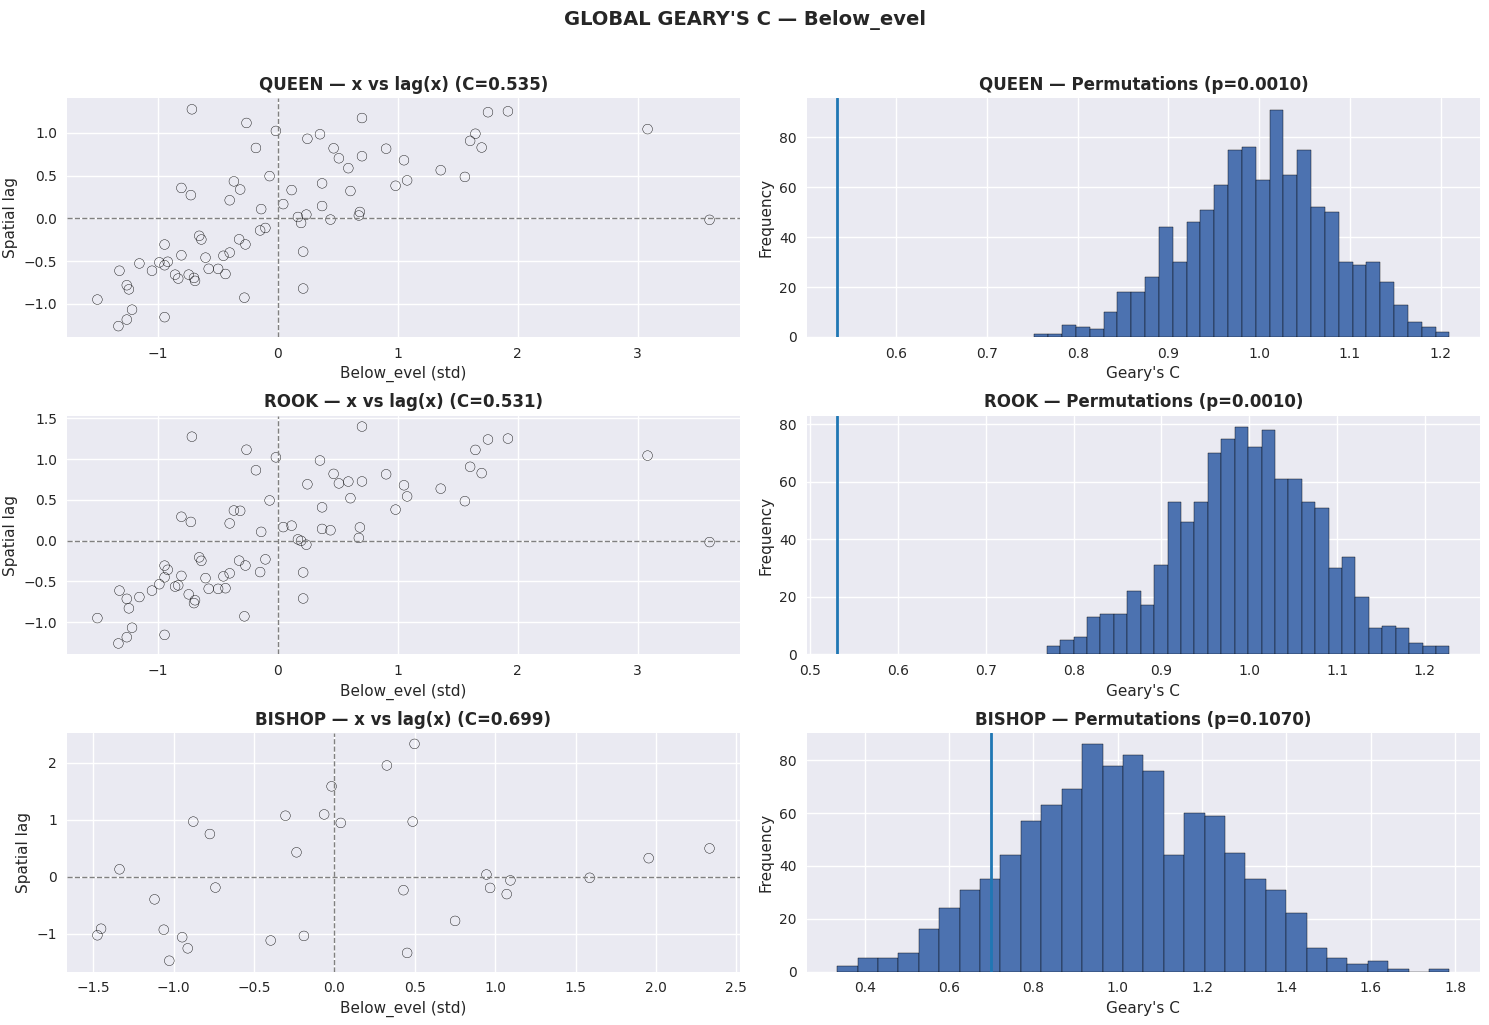

In [7]:
# Inputs
fields = ["Unemp_ment", "Below_evel", "BirthRate", "TeenB_Rate"]

table, fig, out = global_geary(
    gdf,
    fields,
    permutations=999,
    alpha=0.05,
    dashboard_field="Below_evel",
)

display(table)
plt.show()


---